# SINDy utilized on the Lorenz System

In [1]:
import numpy as np
import logging
from scipy.integrate import solve_ivp
from derivative import dxdt
from typing import Tuple
import matplotlib.pyplot as plt

In [2]:
def lorenz(_: float, u: np.ndarray, sigma: float, rho: float,
           beta: float) -> np.ndarray:

    x = u[0]
    y = u[1]
    z = u[2]
    dx_dt = sigma * (y - x)
    dy_dt = x * (rho - z) - y
    dz_dt = x * y - beta * z

    return np.hstack((dx_dt, dy_dt, dz_dt))

def generate_u(t: np.ndarray) -> np.ndarray:
    u0 = np.array([-8, 8, 27])
    result = solve_ivp(fun=lorenz,
                       t_span=(t[0], t[-1]),
                       y0=u0,
                       t_eval=t,
                       args=(SIGMA, RHO, BETA))
    u = result.y.T
    return u

def calculate_finite_difference_derivatives(u: np.ndarray,
                                            t: np.ndarray) -> np.ndarray:

    logging.info("Using finite difference derivatives.")
    uprime = dxdt(u.T, t, kind="finite_difference", k=1).T
    return uprime


In [3]:
def generate_data() -> Tuple[np.ndarray, np.ndarray]:
    """ Generates data u, and calculates its derivatives uprime.
    """
    t0 = 0.001
    dt = 0.001
    tmax = 100
    n = int(tmax / dt)
    t = np.linspace(start=t0, stop=tmax, num=n)

    # Step 1: Generate data u.
    u = generate_u(t)

    # Step 2: Calculate u' from u.
    uprime = calculate_finite_difference_derivatives(u, t)

    return (u, uprime)

In [4]:
"""Utilities related to graphing."""

def style_axis(axis):
    """Styles a graph's x, y, or z axis."""
    # pylint: disable=protected-access
    axis._axinfo["grid"]["color"] = "#dddddd"
    axis._axinfo["grid"]["linewidth"] = 0.4
    axis._axinfo["tick"]["linewidth"][True] = 0.4
    axis._axinfo["tick"]["linewidth"][False] = 0.4
    axis.set_pane_color((0.98, 0.98, 0.98, 1.0))
    axis.line.set_color("#bbbbbb")
    axis.label.set_color("#333333")
    pass


def style_axis3d(axis3d):
    """Styles a 3D graph."""
    axis3d.set_xlabel("x")
    axis3d.set_ylabel("y")
    axis3d.set_zlabel("z")
    axis3d.tick_params(axis="x", colors="#666666")
    axis3d.tick_params(axis="y", colors="#666666")
    axis3d.tick_params(axis="z", colors="#666666")
    style_axis(axis3d.w_xaxis)
    style_axis(axis3d.w_yaxis)
    style_axis(axis3d.w_zaxis)
    axis3d.set_title(axis3d.get_title(), fontdict={"color": "#333333"})


def graph_results(u: np.ndarray, u_approximation: np.ndarray) -> None:
    """Graphs two 3D trajectories side-by-side."""
    sample_count = 20000
    orange = "#EF6C00"

    fig = plt.figure(figsize=plt.figaspect(0.5))

    # Graph trajectory from the true model.
    axis3d = fig.add_subplot(1, 2, 1, projection="3d")
    x = u[0:sample_count, 0]
    y = u[0:sample_count, 1]
    z = u[0:sample_count, 2]
    axis3d.plot3D(x, y, z, orange, linewidth=0.4)
    axis3d.set_title("Original trajectory")
    style_axis3d(axis3d)

    # Graph trajectory computed from model discovered by SINDy.
    axis3d = fig.add_subplot(1, 2, 2, projection="3d")
    x = u_approximation[0:sample_count, 0]
    y = u_approximation[0:sample_count, 1]
    z = u_approximation[0:sample_count, 2]
    axis3d.plot3D(x, y, z, orange, linewidth=0.4)
    axis3d.set_title("SINDy approximation")
    style_axis3d(axis3d)

    plt.show()

In [5]:
def calculate_regression(theta: np.ndarray, uprime: np.ndarray,
                         threshold: float, max_iterations: int) -> np.ndarray:
    # Solve theta * xi = uprime in the least-squares sense.
    xi = np.linalg.lstsq(theta, uprime, rcond=None)[0]
    n = xi.shape[1]

    # Add sparsity.
    for _ in range(max_iterations):
        small_indices = np.abs(xi) < threshold
        xi[small_indices] = 0
        for j in range(n):
            big_indices = np.logical_not(small_indices[:, j])
            xi[big_indices, j] = np.linalg.lstsq(theta[:, big_indices],
                                                 uprime[:, j],
                                                 rcond=None)[0]

    return xi

In [6]:
def create_library(u: np.ndarray, polynomial_order: int) -> np.ndarray:
    """Creates a matrix containing a library of candidate functions.
    For example, if our u depends on x, y, and z, and we specify
    polynomial_order=2, our terms would be:
    1, x, y, z, x^2, xy, xz, y^2, yz, z^2.
    """
    (m, n) = u.shape
    theta = np.ones((m, 1))

    # Polynomials of order 1.
    theta = np.hstack((theta, u))

    # Polynomials of order 2.
    if polynomial_order >= 2:
        for i in range(n):
            for j in range(i, n):
                theta = np.hstack((theta, u[:, i:i + 1] * u[:, j:j + 1]))

    # Polynomials of order 3.
    if polynomial_order >= 3:
        for i in range(n):
            for j in range(i, n):
                for k in range(j, n):
                    theta = np.hstack(
                        (theta, u[:, i:i + 1] * u[:, j:j + 1] * u[:, k:k + 1]))

    # Polynomials of order 4.
    if polynomial_order >= 4:
        for i in range(n):
            for j in range(i, n):
                for k in range(j, n):
                    for l in range(k, n):
                        theta = np.hstack(
                            (theta, u[:, i:i + 1] * u[:, j:j + 1] *
                             u[:, k:k + 1] * u[:, l:l + 1]))

    # Polynomials of order 5.
    if polynomial_order >= 5:
        for i in range(n):
            for j in range(i, n):
                for k in range(j, n):
                    for l in range(k, n):
                        for m in range(l, n):
                            theta = np.hstack(
                                (theta, u[:, i:i + 1] * u[:, j:j + 1] *
                                 u[:, k:k + 1] * u[:, l:l + 1] * u[:, m:m + 1]))

    return theta

In [7]:
def lorenz_approximation(_: float, u: np.ndarray, xi: np.ndarray,
                         polynomial_order: int) -> np.ndarray:
    theta = create_library(u.reshape((1, 3)), polynomial_order)
    return theta @ xi

def compute_trajectory(u0: np.ndarray, xi: np.ndarray, polynomial_order: int) -> np.ndarray:
    t0 = 0.001
    dt = 0.001
    tmax = 100
    n = int(tmax / dt + 1)

    t = np.linspace(start=t0, stop=tmax, num=n)
    result = solve_ivp(fun=lorenz_approximation,
                       t_span=(t0, tmax),
                       y0=u0,
                       t_eval=t,
                       args=(xi, polynomial_order))
    u = result.y.T

    return u

In [8]:
SIGMA = 10
RHO = 28
BETA = 8 / 3

POLYNOMIAL_ORDER = 2

THRESHOLD = 0.025
MAX_ITERATIONS = 10

In [9]:
(u, uprime) = generate_data()
theta = create_library(u, POLYNOMIAL_ORDER)
xi = calculate_regression(theta, uprime, THRESHOLD, MAX_ITERATIONS)
xi

array([[  0.        ,   0.        ,   0.        ],
       [-10.00449518,  27.80496577,   0.        ],
       [ 10.00429024,  -0.95767769,   0.        ],
       [  0.        ,   0.        ,  -2.66700595],
       [  0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.99924596],
       [  0.        ,  -0.99347666,   0.        ],
       [  0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ]])

In [10]:
u0 = np.array([-8, 8, 27])
u_approximation = compute_trajectory(u0, xi, POLYNOMIAL_ORDER)

C:\Users\sande\AppData\Local\Temp\ipykernel_2068\129517075.py:24: MatplotlibDeprecationWarning: The w_xaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use xaxis instead.
  style_axis(axis3d.w_xaxis)
C:\Users\sande\AppData\Local\Temp\ipykernel_2068\129517075.py:25: MatplotlibDeprecationWarning: The w_yaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use yaxis instead.
  style_axis(axis3d.w_yaxis)
C:\Users\sande\AppData\Local\Temp\ipykernel_2068\129517075.py:26: MatplotlibDeprecationWarning: The w_zaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use zaxis instead.
  style_axis(axis3d.w_zaxis)


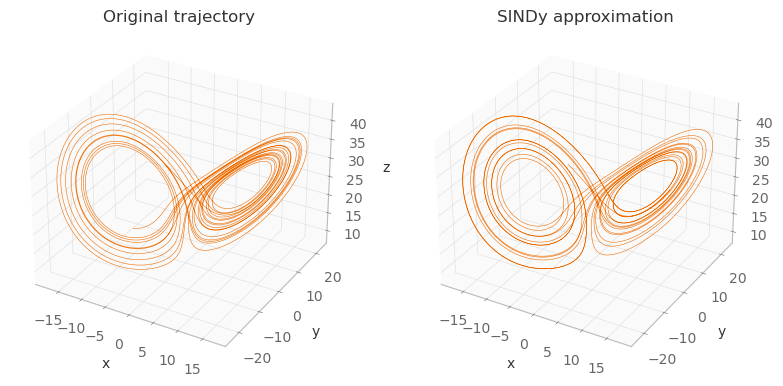

In [11]:
graph_results(u, u_approximation)